In [1]:
# Import Library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import random
import os


Using TensorFlow backend.


In [2]:
# Load the directories
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
print("Files in %r: %s" % (cwd, files))

Train_dir = "Dataset/Train"
Test_dir = "Dataset/test1"

Train_size = len([name for name in os.listdir(Train_dir)])
Test_size = len([name for name in os.listdir(Test_dir)])
print("Number of training images:", Train_size)
print("Number of test images:", Test_size)

Files in 'D:\\Projects\\Dogs Vs Cats': ['.ipynb_checkpoints', 'Dataset', 'models.py', 'models_no_BN.py', 'Prediction.ipynb', 'Saved_Models', 'submission.csv', 'Training.ipynb', '__pycache__']
Number of training images: 25000
Number of test images: 12462


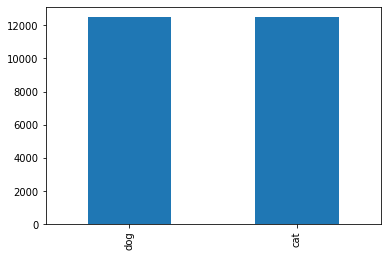

In [3]:
# Prepare the data

# Creating df with training files

filenames = os.listdir(Train_dir)
labels = []

for filename in filenames:
    label = filename.split('.')[0]
    labels.append(label)

df = pd.DataFrame({
    'filename' : filenames,
    'category' : labels
})

# Total count of the categories
df['category'].value_counts().plot.bar()


In [4]:
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [5]:
df.tail()

,filename,category
24995,dog.9995.jpg,dog
24996,dog.9996.jpg,dog
24997,dog.9997.jpg,dog
24998,dog.9998.jpg,dog
24999,dog.9999.jpg,dog


In [6]:
# Splitting the data into train & validation

Batch_size = 32
split_size = 0.2
Image_width = 150
Image_height = 150
Image_size = (Image_width, Image_height)

train_df, valid_df = train_test_split(df,test_size = split_size)

In [7]:
# Training Generator 

train_datagen = ImageDataGenerator(rescale = 1/255,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    Train_dir,
                                                    x_col = 'filename',
                                                    y_col = 'category',
                                                    target_size = Image_size,
                                                    batch_size = Batch_size,
                                                    class_mode = 'binary'
                                                    )

Found 20000 validated image filenames belonging to 2 classes.


In [8]:
# Validation Generator

valid_datagen = ImageDataGenerator(rescale = 1/255)

valid_generator = train_datagen.flow_from_dataframe(valid_df,
                                                    Train_dir,
                                                    x_col = 'filename',
                                                    y_col = 'category',
                                                    target_size = Image_size,
                                                    batch_size = Batch_size,
                                                    class_mode = 'binary'
                                                    )

for image_data, lables in train_generator:
    print('image shape:', image_data.shape)
    print('lables batch shape;', lables.shape)
    break


Found 5000 validated image filenames belonging to 2 classes.
image shape: (32, 150, 150, 3)
lables batch shape; (32,)


In [9]:
#Once you've define the network, you can instantiate it

from models import model
model = model()


W0529 19:41:05.496624 12472 deprecation.py:506] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 37, 37, 64)        2

In [10]:
epochs = 100
adam = Adam(lr=0.001,beta_1 = 0.9,beta_2 = 0.999)

model.compile(loss = 'binary_crossentropy',optimizer = adam, metrics = ['accuracy'])


callback = EarlyStopping(monitor = 'val_loss',
                         patience = 10,
                         mode = 'min',
                         verbose = 1,
                         restore_best_weights = True
                         )
lr = ReduceLROnPlateau(monitor = 'val_loss',
                       factor = 0.2,
                       patience = 10,
                       verbose = 1,
                       min_lr = 0.00001)

history = model.fit_generator(train_generator,
                              epochs = epochs,
                              validation_data = valid_generator,
                              steps_per_epoch = train_df.shape[0]//Batch_size,
                              validation_steps = valid_df.shape[0]//Batch_size,
                              callbacks = [callback,lr],
                              verbose = 2)



W0529 19:41:05.624625 12472 deprecation.py:323] From c:\program files\python37\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
625/625 - 515s - loss: 0.7504 - acc: 0.6043 - val_loss: 0.6312 - val_acc: 0.6216
Epoch 2/100
625/625 - 157s - loss: 0.5929 - acc: 0.6867 - val_loss: 0.5392 - val_acc: 0.7224
Epoch 3/100
625/625 - 123s - loss: 0.5445 - acc: 0.7262 - val_loss: 0.6785 - val_acc: 0.6376
Epoch 4/100
625/625 - 116s - loss: 0.5101 - acc: 0.7484 - val_loss: 0.5107 - val_acc: 0.7512
Epoch 5/100
625/625 - 123s - loss: 0.4723 - acc: 0.7773 - val_loss: 0.4247 - val_acc: 0.8085
Epoch 6/100
625/625 - 120s - loss: 0.4307 - acc: 0.7995 - val_loss: 0.3848 - val_acc: 0.8281
Epoch 7/100
625/625 - 128s - loss: 0.3864 - acc: 0.8278 - val_loss: 0.8126 - val_acc: 0.6781
Epoch 8/100
625/625 - 116s - loss: 0.3543 - acc: 0.8424 - val_loss: 0.3289 - val_acc: 0.8490
Epoch 9/100
625/625 - 121s - loss: 0.3263 - acc: 0.8586 - val_loss: 0.3080 - val_acc: 0.8652
Epoch 10/100
625/625 - 116s - loss: 0.3045 - acc: 0.8683 - val_loss: 0.3536 - val_acc: 0.8476
Epoch 11/100
625/625 - 130s - loss: 0.2889 - acc: 0.8753 - val_loss: 

Epoch 89/100
Restoring model weights from the end of the best epoch.

Epoch 00089: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
625/625 - 117s - loss: 0.1424 - acc: 0.9449 - val_loss: 0.1178 - val_acc: 0.9517
Epoch 00089: early stopping


dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


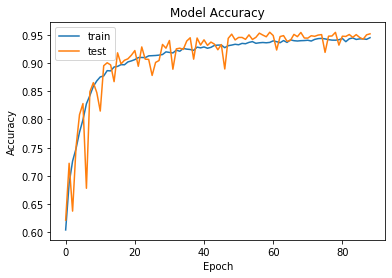

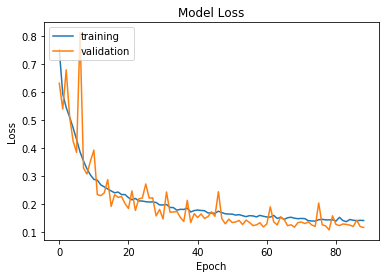

In [11]:
# Plot the accuracy and loss curves

print(history.history.keys())

# Results on Training and Validation Set

training_acc  = history.history['acc']
training_loss = history.history['loss']

validation_acc  = history.history['val_acc']
validation_loss = history.history['val_loss']

epochs = range(len(training_acc))

# Plot Training and Validation Accuracy

plt.plot(epochs,training_acc)
plt.plot(epochs,validation_acc)
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train','test'], loc = 'upper left')
plt.figure()

# Plot Training and Validation Loss 

plt.plot(epochs,training_loss)
plt.plot(epochs,validation_loss)
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['training','validation'], loc = 'upper left')
plt.show()

In [12]:
# after training, save your model parameters in the dir 'saved_models'
model.save('Saved_Models/Dogs_VS_Cats_model_03.h5')